# [Layered VQE](https://arxiv.org/abs/2102.05566) combined with [CVaR](https://arxiv.org/pdf/1907.04769.pdfhttps://arxiv.org/pdf/1907.04769.pdf) for Combanitorial Optimization Problem

***
### Authors: **Walid El Maouaki** and **Atharva Vidwans**
***

### **Theory for LVQE approach**

"Suppose we use a problem encoding that requires $n$ qubits. We start the algorithm with an ansatz with no entangling gates and one $\mathrm{R}_{y}$ gate acting on each qubit, where $\mathrm{R}_{y}$ is the single qubit rotation through an angle $\theta$ around the $y$-axis, the unitary matrix is defined as $\mathrm{R}_{y}(\theta) \equiv e^{-i \frac{\theta}{2} \mathrm{Y}}$, and $\mathrm{Y}$ is the Pauli $\mathrm{Y}$ operator. The parameters of these $\mathrm{R}_{y}$ gates are initialized uniformly randomly on $[0,2 \pi] .$ We denote the parameters for this layer of gates (Layer 0 in Fig. 2) as $\theta_{0}$ and the layer as $U_{0}\left(\theta_{0}\right) .$ The quantum state after applying the circuit to the initial state $|0\rangle$ is denoted as $\left|\psi_{0}\left(\theta_{0}\right)\right\rangle \equiv U_{0}\left(\theta_{0}\right)|0\rangle .$ We then proceed to the conventional VQE routine and iteratively update the parameters $\boldsymbol{\theta}_{0}$ to minimize the cost function $\left\langle\psi_{0}\left(\boldsymbol{\theta}_{0}\right)|\mathcal{H}| \psi_{0}\left(\boldsymbol{\theta}_{0}\right)\right\rangle .$ In conventional VQE, this iterative procedure is run until convergence; but in L-VQE, we stop after a fixed
number of iterations and then add another set of gates to the ansatz. The conventional strategy can indeed produce a better result at this step, but after adding the new set of gates, it may more easily get trapped in a local minimum in the subsequent optimization procedure. In our experiments, the number of iterations is picked empirically and increases linearly as system size grows.

The newly added set of gates includes the $\mathrm{R}_{y}$ gates and CNOT gates that act on nearest-neighbor qubits. Another way to describe this whole procedure is that we embed the obtained parameterized circuit into a deeper circuit. We denote this newly added layer of the circuit $U_{1}\left(\boldsymbol{\theta}_{1}\right)$, (Layer 1 in Fig. 2). The newly added parameters $\boldsymbol{\theta}_{1}$ are initialized as zero. Note that here since $\mathrm{R}_{y}(0)=\mathrm{I}$ and $\mathrm{CNOT}^{2}=\mathrm{I}$, where $\mathrm{I}$ is the identity matrix, the quantum state becomes
$$
\left|\psi_{1}\left(\boldsymbol{\theta}_{0}, \boldsymbol{\theta}_{1}\right)\right\rangle \equiv U_{1}\left(\boldsymbol{\theta}_{1}\right) U_{0}\left(\boldsymbol{\theta}_{0}\right)|0\rangle=U_{0}\left(\boldsymbol{\theta}_{0}\right)|0\rangle=\left|\psi_{0}\left(\boldsymbol{\theta}_{0}\right)\right\rangle
$$ 
Therefore, initializing the newly added parameters as zeros guarantee that the cost function that we are optimizing will not change after adding this new layer. However, one may add small random perturbation to the parameters before optimization is continued. In that sense, $\boldsymbol{\theta}_{1}$ are not initialized with zero but with small random numbers. As we proceed to the optimization process, iteratively updating the parameters $\boldsymbol{\theta}_{0}, \boldsymbol{\theta}_{1}$ to minimize the cost function $\left\langle\psi_{1}\left(\boldsymbol{\theta}_{0}, \boldsymbol{\theta}_{1}\right)|\mathcal{H}| \psi_{1}\left(\boldsymbol{\theta}_{0}, \boldsymbol{\theta}_{1}\right)\right\rangle$, initializing with small random numbers may
be useful to avoid local minima and speed up the optimization in general. At this point, we can either let the optimization run until convergence or repeat the previous process, stop at a fixed number of iterations, and add another set of gates to the circuit and then optimize."

The pseudo code of the algorithm is presented in Algorithm:

<img src="pseudocode.PNG" height="70%" width="70%">

The typical LVQE ansatz with 2 layers and 6 qubits is as shown below:

<img src="Ansatz.PNG" height="70%" width="70%">

#### **Importing standard Qiskit libraries and other necessary modules**

In [2]:
# Required Qiskit Libraries
from qiskit import QuantumCircuit, Aer
from qiskit.tools.jupyter import *
from ibm_quantum_widgets import *
from qiskit.algorithms.optimizers import ADAM, CG, GSLS, NELDER_MEAD, NFT, POWELL, SPSA, TNC, COBYLA, L_BFGS_B, SLSQP, AQGD, P_BFGS
from qiskit.algorithms import VQE, QAOA
from qiskit.opflow import I, X, Z, Y, PauliExpectation, CVaRExpectation
from qiskit.utils import QuantumInstance
from qiskit.optimization.problems import QuadraticProgram
from qiskit.optimization.algorithms import MinimumEigenOptimizer
from qiskit.optimization.applications.ising.common import sample_most_likely
from qiskit.optimization.applications.ising import tsp
from qiskit.circuit import ParameterVector
from qiskit.aqua.algorithms import NumPyMinimumEigensolver

import itertools
import numpy as np
import pandas as pd
import networkx as nx

# Visualization tool
from qiskit.visualization import *
import matplotlib.pyplot as plt
import matplotlib.axes as axes

# Ignore Deprecation Warnings
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

print("All modules imported successfully")

All modules imported successfully


***
### **Layer VQE circuit construction** ###
***

Module concentrates on circuit generation for LVQE. The only difference in the LVQE and VQE is the training of the  circuit. In LVQE as explained above the circuit is trained layer-wise which is contrast to conventional VQE appraoch. In conventional VQE the circuit is trained only once completely. Thus this same circuit can be used for VQE approach with different training techniques.    

In [3]:
# Create the structure of the Layers
def Layer_VQE(n,theta):
    
    m=0
    q=QuantumCircuit(n)
    if (n % 2) == 0:
        #Sub Layer1
        for _ in range(2):
            for i, j in itertools.zip_longest(range(0,n-1,2), range(0,n,1)):
                if i!=None:
                    q.cx(i,i+1)
                if j!=None:
                    q.ry(theta[m],j)
                    m+=1
    #=========================
        #Sub Layer2
        for _ in range(2):
            for i, j in itertools.zip_longest(range(1,n-2,2), range(1,n-1,1)):
                if i!=None:
                    q.cx(i,i+1)
                if j!=None:
                    q.ry(theta[m],j)
                    m+=1
    else:
        #SubLayer1
        for _ in range(2):
            for i, j in itertools.zip_longest(range(0,n-1,2), range(0,n-1,1)):
                if i!=None:
                    q.cx(i,i+1)
                if j!=None:
                    q.ry(theta[m],j)
                    m+=1
        #==========================
        #SubLayer2
        for _ in range(2):
            for i, j in itertools.zip_longest(range(1,n-1,2), range(1,n,1)):
                if i!=None:
                    q.cx(i,i+1)
                if j!=None:
                    q.ry(theta[m],j)
                    m+=1
    return q

In [4]:
# Apply l number of Layers
def Layers(theta,n,l):
    num_param=4*(n-1)
    if l==0:
        qc=QuantumCircuit(n)
        [qc.ry(theta[p],p) for p in range(n)]

    else:
        qc=QuantumCircuit(n)
        # Apply layer 0
        [qc.ry(theta[p],p) for p in range(n)]
        # Apply Layers l
        for j in range(1,l+1):
            qc=qc+Layer_VQE(n,theta[n+(j-1)*num_param:n+j*num_param])
    return qc

In [6]:
def Layers_optimization(n,l,H,iteration:list,expectation=None,shots=1024,small_random=False,printing=True):
    if len(iteration)!=l+1:
        raise ValueError('The lenght of you iteration list must equal the maximum number of Layers l+1')
            
    num_para=4*(n-1) # The number of parameters in each Layer (except Layer 0).
    # Store intermidiate data:
    counts =list_of_lists = [[] for i in range(l+1)] # it stores the number of iterations for each Layer
    values =list_of_lists = [[] for i in range(l+1)] # it stores the energy after each iteration for each Layer

    for i in range(0,l+1):
        # function to append intermidiate data to plot it:
        def store_intermediate_result(eval_count, parameters, mean, std):
            counts[i].append(eval_count)
            values[i].append(mean)

        # if i==0 means that you will apply the firs simple layer (it is isolated because it is different from the other layers):
        if i==0:
            params =  ParameterVector('θ', n)
            ansatz = Layers(params,n,i)
            parameters = np.random.uniform(0,2*np.pi,size=(n)).tolist() # Initialize the Layer 0 parameters randomly between [0,2pi]

            vqe = VQE(ansatz = ansatz, optimizer = COBYLA(maxiter=iteration[i]), initial_point=parameters, expectation=expectation,
                      quantum_instance=QuantumInstance(backend=Aer.get_backend("qasm_simulator"),shots=shots), max_evals_grouped=1,callback=store_intermediate_result)
            result = vqe.compute_minimum_eigenvalue(operator=H)

            parameters = result.optimal_point.tolist()
        # Aplly Layer 1...l:
        else:
            params =  ParameterVector('θ', n+num_para*i)
            ansatz = Layers(params, n,i)
            if small_random==True:
                add = np.random.uniform(1e-10,1e-5,size=(num_para)).tolist()
            else:
                add=np.zeros(num_para).tolist() # Initialize the Layer 1...l parameters to 0
            parameters =parameters + add

            vqe = VQE(ansatz=ansatz, optimizer = COBYLA(maxiter=iteration[i]), initial_point=parameters, expectation=expectation,
                      quantum_instance=QuantumInstance(backend=Aer.get_backend("qasm_simulator"),shots=shots), max_evals_grouped=1, callback=store_intermediate_result)
            result = vqe.compute_minimum_eigenvalue(operator=H)

            parameters = result.optimal_point.tolist()

        if printing==True:
            print("Optimization after Layer {}:".format(i),result.optimal_value)

    return result, counts, values, ansatz

***
### **Formulating the Hamiltonian :** ###
***

After carefully designing the Ansatz we move forward to formulating the Hamiltonian for the specific TSP problem. For a graph with 3 nodes the Hamiltonian is represented using 9 qubits, i.e. N<sup>2</sup>, where N is the number of nodes. 
This Hamiltonain formulation is extracted from this <font color='green'> [notebook](https://qiskit.org/documentation/tutorials/optimization/6_examples_max_cut_and_tsp.html#Traveling-Salesman-Problem)</font>

distance between the nodes is: 
 [[ 0. 48. 91.]
 [48.  0. 63.]
 [91. 63.  0.]]


The Graph for this Combanitorial Optimization problem is shown below


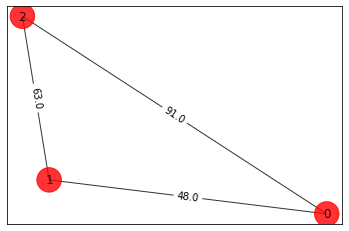

In [7]:
def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

# Generating a graph of 3 nodes
nodes = 3 # Set this value for changing the number of nodes in the graph 
num_qubits = nodes ** 2
ins = tsp.random_tsp(nodes, seed=123)
print('distance between the nodes is: \n', ins.w)

# Draw the graph
G = nx.Graph()
G.add_nodes_from(np.arange(0, ins.dim, 1))
colors = ['r' for node in G.nodes()]

for i in range(0, ins.dim):
    for j in range(i+1, ins.dim):
        G.add_edge(i, j, weight=ins.w[i,j])

pos = {k: v for k, v in enumerate(ins.coord)}
print("\n\nThe Graph for this Combanitorial Optimization problem is shown below")
draw_graph(G, colors, pos)

This is how the Hamiltonian will appear:

In [8]:
qubitOp, offset = tsp.get_operator(ins)
print('Offset:', offset)
print('Ising Hamiltonian:')
print(qubitOp.print_details())

Offset: 600303.0
Ising Hamiltonian:
IIIIIIIIZ	(-100069.5+0j)
IIIIZIIII	(-100055.5+0j)
IIIIZIIIZ	(12+0j)
IIIIIIIZI	(-100069.5+0j)
IIIZIIIII	(-100055.5+0j)
IIIZIIIZI	(12+0j)
IIIIIIZII	(-100069.5+0j)
IIIIIZIII	(-100055.5+0j)
IIIIIZZII	(12+0j)
IZIIIIIII	(-100077+0j)
IZIIIIIIZ	(22.75+0j)
ZIIIIIIII	(-100077+0j)
ZIIIIIIZI	(22.75+0j)
IIZIIIIII	(-100077+0j)
IIZIIIZII	(22.75+0j)
IIIIIZIZI	(12+0j)
IIIIZIZII	(12+0j)
IIIZIIIIZ	(12+0j)
IZIIIZIII	(15.75+0j)
ZIIIZIIII	(15.75+0j)
IIZZIIIII	(15.75+0j)
IIZIIIIZI	(22.75+0j)
IZIIIIZII	(22.75+0j)
ZIIIIIIIZ	(22.75+0j)
IIZIZIIII	(15.75+0j)
IZIZIIIII	(15.75+0j)
ZIIIIZIII	(15.75+0j)
IIIIIZIIZ	(50000+0j)
IIZIIIIIZ	(50000+0j)
IIZIIZIII	(50000+0j)
IIIIZIIZI	(50000+0j)
IZIIIIIZI	(50000+0j)
IZIIZIIII	(50000+0j)
IIIZIIZII	(50000+0j)
ZIIIIIZII	(50000+0j)
ZIIZIIIII	(50000+0j)
IIIIIIIZZ	(50000+0j)
IIIIIIZIZ	(50000+0j)
IIIIIIZZI	(50000+0j)
IIIIZZIII	(50000+0j)
IIIZIZIII	(50000+0j)
IIIZZIIII	(50000+0j)
IZZIIIIII	(50000+0j)
ZIZIIIIII	(50000+0j)
ZZIIIIIII	(50000+0j)



In [9]:
ee = NumPyMinimumEigensolver(qubitOp)
result = ee.run()
ground = result.eigenvalue.real
print(ground)

-600101.0


* Now we will copy past this data in a `.txt` file and add a header (so that we can access each column) such as:

$\quad\quad\quad\quad\quad\quad$Paulis     $\;\;\;$   Weight <br>
$\quad\quad\quad\quad\quad\quad$IIIIIIIIZ   $\;\;\;$    (-100069.5+0j)<br>
$\quad\quad\quad\quad\quad\quad$IIIIZIIII     $\;\;\;$   (-100055.5+0j)<br>
$\quad\quad\quad\quad\quad\quad$IIIIZIIIZ    $\;\;\;$    (12+0j)<br>
$\quad\quad\quad\quad\quad\quad$...

* Next is to create a function to convert the `.txt` data to a Hamiltonian that can be read by the `compute_minimum_eigenvalue()` method (for instance: H = -2(Z ^ Z ^ Z ^ Z) + 0.5(I ^ I ^ I ^ I)) we call it `convert_hamiltonian()` where you pass in the path of where you store the `.txt` file:

In [108]:
Paulis = []
Weight = []
Str = ""
sc = 0
ham = qubitOp.print_details()
for i in range(len(ham)):
    
    #print(Str)
    if (ham[i] == '\t' or ham[i] =='\n'):
        if (sc%2==0):
            Paulis.append(Str)
            Str=""
            sc+=1
            i+=1
        else:
            Weight.append(Str)
            Str=""
            sc+=1
            i+=1
    else:
        Str = Str + ham[i]
        
data = {'Paulis':Paulis, 'Weight':Weight}
df = pd.DataFrame(data)
df.to_csv(r'TSP_9.txt', header=True, index=None, sep=' ', mode='w')

In [10]:
def convert_hamiltonian(path:str):
    H=pd.read_csv(path, sep=' ')
    P=H['Paulis']
    W=H['Weight']
    def changeto(rt:str):
        m=1
        for i in range(len(rt)-1):
            rt=list(rt)
            rt.insert(m,'^')
            m+=2
        return ''.join(rt)
    H=''
    for p,w in zip(P,W):
        x=np.real(complex(w))
        if x<0:
            H=H+'-{}*({})'.format(abs(x),changeto(p))
        else:
            H=H+'+{}*({})'.format(abs(x),changeto(p))
    return H

***
# **Start the experiment for** $Layer\;VQE$:
***

Two main concerns are the expressivity and the trainability of the chosen ansatz. First, the ansatz has to be sufficiently expressive, meaning that there should exist parameters with which the ansatz prepares a state suitably close to the solution of the problem. Second, the ansatz has to be trainable, meaning that sufficiently good parameters have to be feasible to find 

When we increase the size of the ansatz, the ansatz becomes more expressive, and we should have a better chance of finding the ground state and reduces the optimization overhead.

Now let define our problem and run the algorithm by adding different layers to make our ansatz more expressive:

In [11]:
# Define variables
H=eval(convert_hamiltonian('TSP_9.txt')) # e.g. H = -2*(Z ^ Z ^ Z ^ Z) + 0.5*(I ^ I ^ I ^ I).
n=nodes**2 # Number of qubits.
l=2 # Number of Layers you want to optimize (add).

In [25]:
%%time
Lvqe=Layers_optimization(n,l,H,[200,100,500])
print('\n')

Optimization after Layer 0: -599319.84375
Optimization after Layer 1: -599905.6259765626
Optimization after Layer 2: -600101.0


CPU times: user 17.1 s, sys: 116 ms, total: 17.2 s
Wall time: 17.2 s


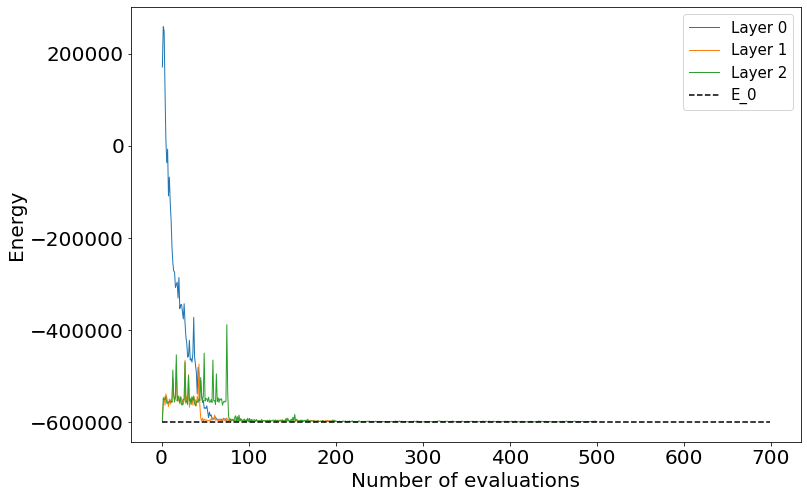

<Figure size 864x576 with 0 Axes>

In [52]:
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams.update({'font.size': 20})
for i in range(0,l+1):
    plt.plot(Lvqe[1][i], Lvqe[2][i], linewidth=1, label='Layer {}'.format(i))
#plt.plot(counts[-1], values[-1], linewidth=1, color="grey", label='Layer{} until cv'.format(l)) # cv: convergence
plt.plot(range(0, 700), -600101.0*np.ones(700), 'k--', linewidth=1.5, label='E_0')

plt.xlabel('Number of evaluations')
plt.ylabel('Energy')
plt.legend(loc='upper right', fontsize=15)
plt.show()

As we can see, the line for Layer 0 is starting from a point that is far away from the exact one and then it converges. And for Layer 1 it starts near the exact solution because we fed the optimized parameters and the minimizer start with that point which already approaches the solution, then it starts its optimization and converges quickly (the small divergence is appearing because new parameters (different from 0) have been set for Layer 1).

**Result for solving the TSP using Layer VQE**

In [18]:
print("Results after solving the TSP problem on LVQE are shown below \n")
print('energy:', Lvqe[0].eigenvalue.real)
print('time:', Lvqe[0].optimizer_time)
print('tsp objective:', Lvqe[0].eigenvalue.real + offset)
x = sample_most_likely(Lvqe[0].eigenstate)
print('feasible:', tsp.tsp_feasible(x))
z = tsp.get_tsp_solution(x)
print('solution:', z)
print('solution objective:', tsp.tsp_value(z, ins.w))

Results after solving the TSP problem on LVQE are shown below 

energy: -600101.0
time: 46.235236167907715
tsp objective: 202.0
feasible: True
solution: [2, 0, 1]
solution objective: 202.0


***
# **Comaprison of LVQE with Classical Eigen solver, conventional VQE and LVQE-CVaR**
***

## Ground State Energy Calculation using Classical Eigen Solver:

In [14]:
ee = NumPyMinimumEigensolver(qubitOp)
result_exact = ee.run()

print("Results after solving the TSP problem Classicaly are shown below \n")
print('energy:', result_exact.eigenvalue.real)
print('tsp objective:', result_exact.eigenvalue.real + offset)
x = sample_most_likely(result_exact.eigenstate)
print('feasible:', tsp.tsp_feasible(x))
z = tsp.get_tsp_solution(x)
print('solution:', z)

Results after solving the TSP problem on LVQE are shown below 

energy: -600101.0
tsp objective: 202.0
feasible: True
solution: [0, 1, 2]


## Ground State Energy Calculation using Conventional VQE approach:

In [36]:
# Multiple Ansatz from 0 to l Layers
def usual_vqe(n,l,H,maxiter,shots=1024,expectation=None,one_ansatz=False,printing=True):
    num_para=4*(n-1)
    counts_vqe_2 = [[] for i in range(l+1)] # it stores the number of iterations for each Layer
    values_vqe_2 = [[] for i in range(l+1)] # it stores the energy after each iteration for each Layer
        
    if one_ansatz==True:
        x=l
    else:
        x=0
    
    for i in range(x,l+1):
    
        def store_intermediate_result_vqe(eval_count, parameters, mean, std):
            counts_vqe_2[i].append(eval_count)
            values_vqe_2[i].append(mean)
    
        if i==0:
            params2 =  ParameterVector('θ', n)
        else:
            params2 =  ParameterVector('θ', n+num_para*i)
        ansatz_vqe = Layers(params2, n,i)
        vqe_usual = VQE(ansatz=ansatz_vqe, optimizer = COBYLA(maxiter=maxiter),max_evals_grouped=1,
                  quantum_instance=QuantumInstance(backend=Aer.get_backend("qasm_simulator"),shots=shots),callback=store_intermediate_result_vqe)
        result_vqe = vqe_usual.compute_minimum_eigenvalue(operator=H)
        if printing==True:
            print('Energy by VQE with Ansatz constructed by Layer 0 to {}'.format(i),result_vqe.optimal_value)
    return counts_vqe_2, values_vqe_2, result_vqe

In [33]:
%%time
l=4
vqe_test=usual_vqe(n,l,H,maxiter=500)
print('\n')

Energy by VQE with Ansatz constructed by Layer 0 to 0 -594045.1015625001
Energy by VQE with Ansatz constructed by Layer 0 to 1 -581546.5742187502
Energy by VQE with Ansatz constructed by Layer 0 to 2 -570811.2978515625
Energy by VQE with Ansatz constructed by Layer 0 to 3 -547172.0927734375
Energy by VQE with Ansatz constructed by Layer 0 to 4 -515146.375


CPU times: user 6min 8s, sys: 950 ms, total: 6min 8s
Wall time: 6min 9s


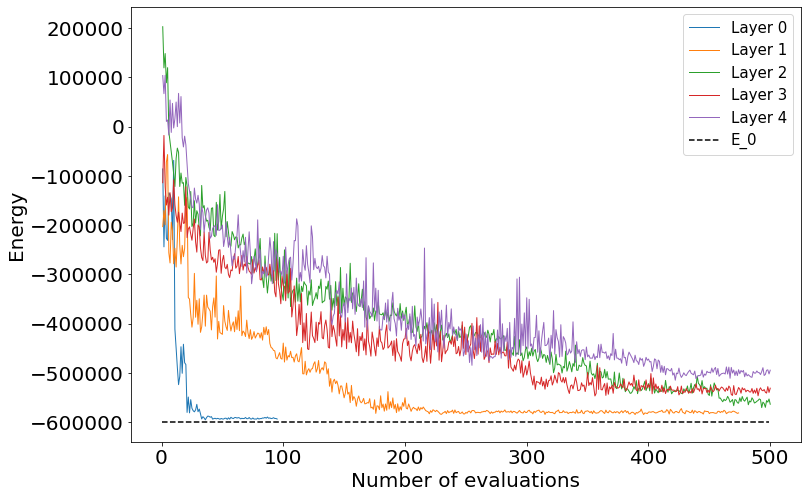

In [34]:
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams.update({'font.size': 20})
for i in range(0,l+1):
    plt.plot(vqe_test[0][i], vqe_test[1][i], linewidth=1, label='Layer {}'.format(i))
plt.plot(range(0, 500), -600101.0*np.ones(500), 'k--', linewidth=1.5, label='E_0')

plt.xlabel('Number of evaluations')
plt.ylabel('Energy')
plt.legend(loc='upper right', fontsize=15)
plt.show()

The Conventional VQE approach gets stuck in local minima thus giving incorrect ground energies for Hamiltonain. Furthermore, we have tested the Conventional VQE on 5 different ansatz  which performs poorly for the given TSP problem as the ansatz becomes more expressive. 

# Ground State Energy Calculation using LVQE-CVaR approach

In [21]:
%%time
l=3
expectation = CVaRExpectation(0.5, PauliExpectation())# CVAR expectation.
Lvqe_cvar=Layers_optimization(n,l,H,[100,100,100,100], expectation=expectation)
print('\n')

Optimization after Layer 0: -600101.0
Optimization after Layer 1: -600101.0
Optimization after Layer 2: -600101.0
Optimization after Layer 3: -600101.0


CPU times: user 51.9 s, sys: 3.2 s, total: 55.1 s
Wall time: 55.2 s


It can be seen that our proposed LVQE-CVaR approach reach the optimal solution (which is verified using a Classical Eigen Solver) most of the time and with only a few iterations. Hence, the CVAR approach is a powerful objective function.

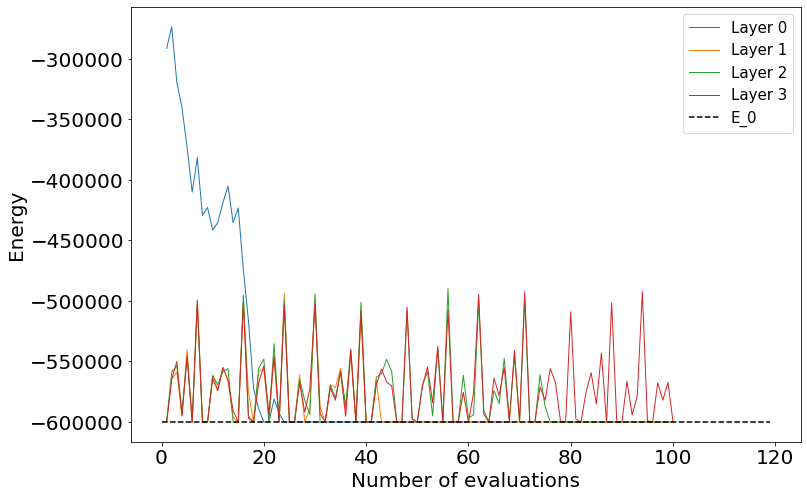

In [22]:
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams.update({'font.size': 20})
for i in range(0,l+1):
    plt.plot(Lvqe_cvar[1][i], Lvqe_cvar[2][i], linewidth=1, label='Layer {}'.format(i))
plt.plot(range(0, 120), -600101.0*np.ones(120), 'k--', linewidth=1.5, label='E_0')

plt.xlabel('Number of evaluations')
plt.ylabel('Energy')
plt.legend(loc='upper right', fontsize=15)
plt.show()

**Result for solving the TSP using L-VQE-CVAR**

In [23]:
print("Results after solving the TSP problem on LVQE-CVaR are shown below \n")
print('energy:', Lvqe_cvar[0].eigenvalue.real)
print('time:', Lvqe_cvar[0].optimizer_time)
print('tsp objective:', Lvqe_cvar[0].eigenvalue.real + offset)
x = sample_most_likely(Lvqe_cvar[0].eigenstate)
print('feasible:', tsp.tsp_feasible(x))
z = tsp.get_tsp_solution(x)
print('solution:', z)
print('solution objective:', tsp.tsp_value(z, ins.w))

Results after solving the TSP problem on LVQE-CVaR are shown below 

energy: -600101.0
time: 15.048617124557495
tsp objective: 202.0
feasible: True
solution: [1, 2, 0]
solution objective: 202.0


# Multiple qubits: LVQE vs VQE:

Below we are going to compare Layer VQE with VQE for multiple numbers of qubits (4,9, and 16 qubits, each case is shown in a plot). Layer VQE we are going to optimize the layers as: Layer 0, Layer 0,1, and then Layer 0,1,2. For VQE we will fix the Ansatz which will contain Layer 0 + Layer 1 + Layer 2 (as shown and the second figure above).

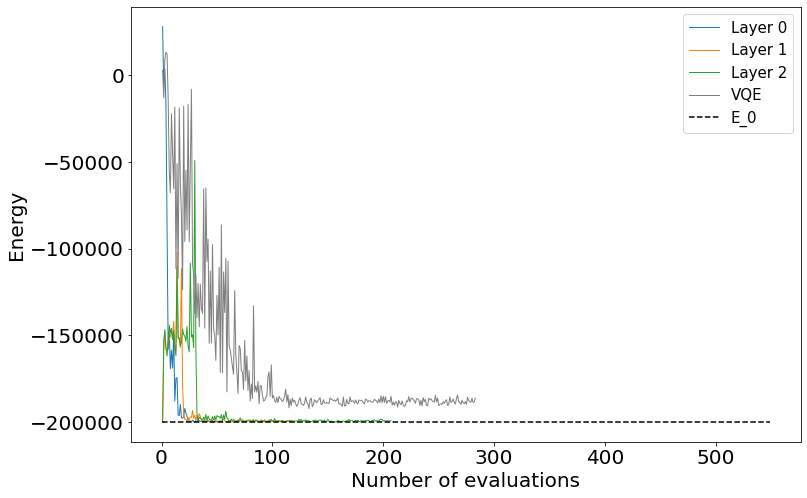

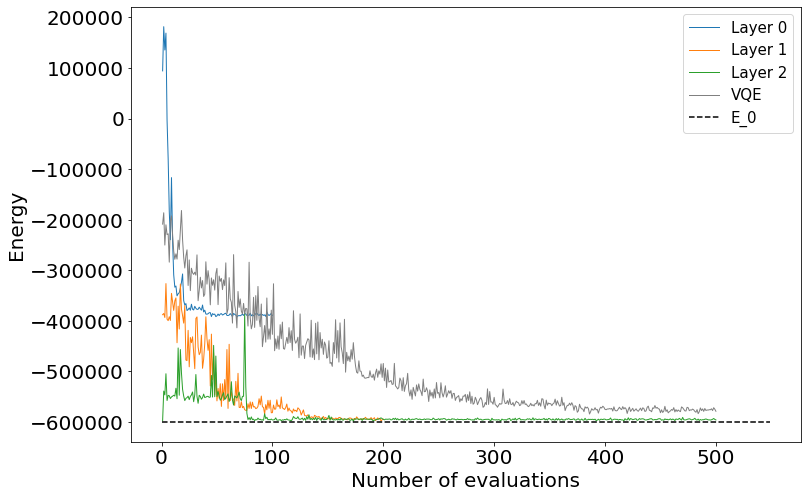

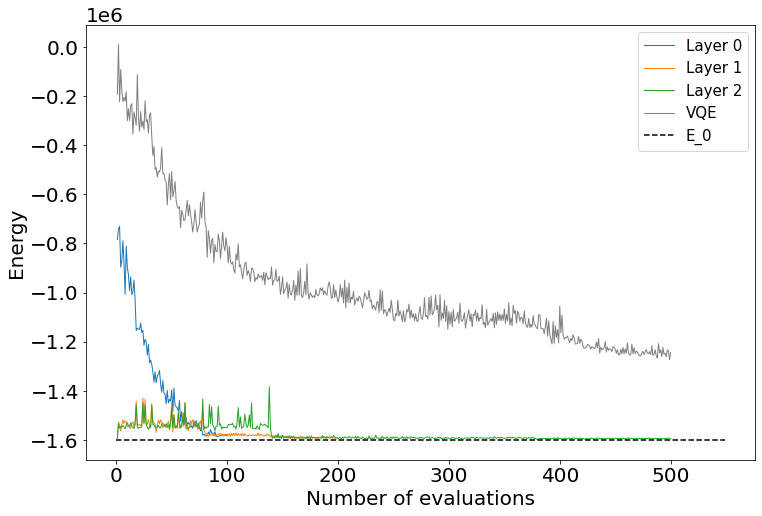

In [37]:
H_qubit=['TSP_4.txt','TSP_9.txt','TSP_16.txt']
c=0
l=2
for k in range(2,5):
    # k is the number of nodes
    H_eval=eval(convert_hamiltonian(H_qubit[c]))
    c+=1
    Layer=Layers_optimization(k**2,l,H_eval,[100,200,500],printing=False)
    vqe=usual_vqe(k**2,l,H_eval,maxiter=500, one_ansatz=True,printing=False)
    
    plt.rcParams['figure.figsize'] = (12, 8)
    plt.rcParams.update({'font.size': 20})
    for i in range(0,2+1):
        plt.plot(Layer[1][i], Layer[2][i], linewidth=1, label='Layer {}'.format(i))
    plt.plot(vqe[0][l], vqe[1][l],linewidth=1, color="grey", label='VQE')
    if k==2:
        plt.plot(range(0, 550),-199952.0*np.ones(550), 'k--', linewidth=1.5, label='E_0')
    elif k==3:
        plt.plot(range(0, 550),-600101.0*np.ones(550), 'k--', linewidth=1.5, label='E_0')
    elif k==4:
        plt.plot(range(0, 550),-1600560.0*np.ones(550), 'k--', linewidth=1.5, label='E_0')
    
    plt.xlabel('Number of evaluations')
    plt.ylabel('Energy')
    plt.legend(loc='upper right', fontsize=15)
    plt.show()

VQE starts overshooting the optimal value by increasing the number of qubits and that because the optimizer has to optimize a large number of parameters at once, whereas Layer VQE optimizes layer by layer which helps to converge to the optimal solution.